In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import utils

# TODO
- create a fully connected neural network with pytorch
- check the performance of the model

---

## Load Data

In [14]:
train = pd.read_csv("datasets/main_ordinal_updated_train.csv")
test = pd.read_csv("datasets/main_ordinal_updated_test.csv")

X_train = train.drop(columns=["price"])
X_test = test.drop(columns=["price"])

y_train = train["price"]
y_test = test["price"]

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Shape of the train set: {X_train.shape} {y_train.shape}")
print(f"Shape of the test set: {X_test.shape} {y_test.shape}")

Shape of the train set: (156544, 18) (156544,)
Shape of the test set: (39136, 18) (39136,)


In [15]:
# setting dataset for loader
class HousingDataset(Dataset):
    def __init__(self, data, label):
        super().__init__()
        
        self.data = data
        self.label = label

    def __getitem__(self, index):        
        data_point = self.data[index].astype(np.float32)
        data_label = self.label[index]
        
        return data_point, data_label

    def __len__(self):
        return self.data.shape[0]

## Train and Eval functions

In [16]:
def train(network, optimizer, loss_fn, train_loader, device):
    
    for train_inputs, train_labels in tqdm(train_loader):

        train_inputs = train_inputs.to(device)
        train_labels = train_labels.reshape((-1,1)).to(device)

        preds = network(train_inputs)
        
        loss = loss_fn(preds, train_labels.float())

        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    return loss.item()

def evalf(network, test_loader, device):
    
    model_preds = []
    true_labels = []
    eval_info = {}

    with torch.no_grad():
        for val_inputs, val_labels in tqdm(test_loader):

            val_inputs = val_inputs.to(device)
            val_labels = val_labels.reshape((-1,1)).to(device)
            
            preds = network(val_inputs)
 
            model_preds += preds.detach().cpu().numpy().astype(int).tolist()
            true_labels += val_labels.detach().cpu().numpy().tolist()
  
    eval_info["model_preds"] = model_preds
    eval_info["true_labels"] = true_labels
    
    return eval_info

## Set Network Utils

In [33]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.linear1 = torch.nn.Linear(18, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.linear2 = torch.nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.linear3 = torch.nn.Linear(32, 1)

    def forward(self, x):

        x = self.linear1(x)
        x = self.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.linear3(x)

        return x

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
epochs = 15

train_loader = DataLoader(HousingDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(HousingDataset(X_test, y_test), shuffle=False)

net = FCNN().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

### Training

In [39]:
train_losses = []

net.train()

for e in range(epochs):
    l = train(net, optimizer, criterion, train_loader, device)
    train_losses.append(l)

    print(f"Epoch-{e+1}:")
    print(f"Train Loss: {np.sqrt(l)}")

    
net.eval()    
evals = evalf(net, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 373.30it/s]


Epoch-1:
Train Loss: 759.86018450765


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 371.80it/s]


Epoch-2:
Train Loss: 281.7677179433442


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 353.14it/s]


Epoch-3:
Train Loss: 247.1726212336229


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 373.67it/s]


Epoch-4:
Train Loss: 335.4914771644728


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 358.40it/s]


Epoch-5:
Train Loss: 276.99748983519686


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 370.20it/s]


Epoch-6:
Train Loss: 277.02374672579964


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 370.63it/s]


Epoch-7:
Train Loss: 319.5133262087827


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 358.73it/s]


Epoch-8:
Train Loss: 312.99229972556833


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 361.76it/s]


Epoch-9:
Train Loss: 271.68789538733597


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 363.56it/s]


Epoch-10:
Train Loss: 281.36078373682426


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 361.26it/s]


Epoch-11:
Train Loss: 293.2080106340889


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 350.00it/s]


Epoch-12:
Train Loss: 284.68100294452387


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 355.00it/s]


Epoch-13:
Train Loss: 310.1221281608263


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:07<00:00, 347.74it/s]


Epoch-14:
Train Loss: 324.27968252729


100%|█████████████████████████████████████████████████████████████████████████████| 2446/2446 [00:06<00:00, 366.78it/s]


Epoch-15:
Train Loss: 297.0472263588738


100%|██████████████████████████████████████████████████████████████████████████| 39136/39136 [00:31<00:00, 1249.08it/s]


## Results

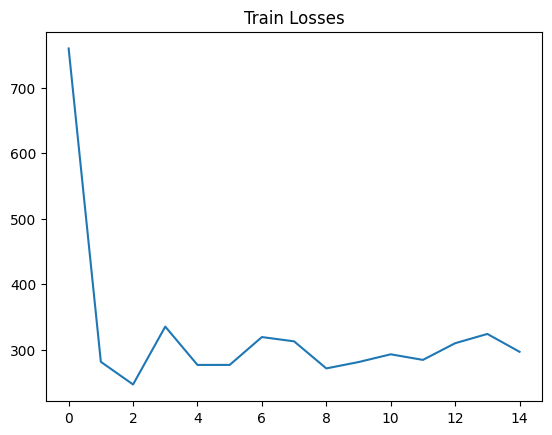

In [40]:
plt.figure()
plt.plot(range(len(train_losses)), np.sqrt(train_losses))
plt.title("Train Losses")
plt.show()

## Results

In [41]:
print("RMSE:", np.sqrt(mean_squared_error(evals["true_labels"], evals["model_preds"])))
print("MAPE:", mean_absolute_percentage_error(evals["true_labels"], evals["model_preds"]))
print("R2:", r2_score(evals["true_labels"], evals["model_preds"]))

RMSE: 262.5189179609881
MAPE: 0.16799829119790471
R2: 0.6132039604040762
